In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = r"F:/Git Hub rep/CRC/neew/PyBaMM/Untitled Folder/data/esoh/"
oCV_DIR = r"F:/Git Hub rep/CRC/neew/PyBaMM/Untitled Folder/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

from scipy.io import savemat


In [2]:
## Added from old vrsion 


In [3]:
parameter_values = get_parameter_values()

In [4]:
parameter_values.search("diffu")

EC diffusivity [m2.s-1]	2e-18
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_PeymanMPM at 0x000001E49C329670>
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Negative electrode diffusion coefficient [m2.s-1]	8e-14
Negative electrode diffusivity [m2.s-1]	<function graphite_diffusivity_PeymanMPM at 0x000001E49C2F3B80>
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Positive electrode diffusion coefficient [m2.s-1]	8e-15
Positive electrode diffusivity [m2.s-1]	<function NMC_diffusivity_PeymanMPM at 0x000001E49C2F3AF0>
Typical lithium ion diffusivity [m2.s-1]	5.34e-10


In [5]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
# spm.print_parameter_info()
param=spm.param

In [6]:


cell = 4




In [7]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")

drive_cycle = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_default_5Ah.csv", comment="#", header=None).to_numpy()
drive_cycle2 = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\US06_GM_5Ah.csv", comment="#", header=None).to_numpy()

experiment = pybamm.Experiment( # defult D.C. DRC-DRC *1.25
    [
        ("Run US06 (A) for 1 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for .9 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run US06 (A) for 1 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 1.9 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes",     
        )

    ]*520,
    drive_cycles={"US06": drive_cycle},
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment2 = pybamm.Experiment( #lab cycling
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *300,
    # ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)

## GM_DCRDCR
experiment3 = pybamm.Experiment( #GM_ DRC-DRC
    [
        ("Run US06_GM_5Ah (A) for 1 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for .6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run US06_GM_5Ah (A) for 1 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 1 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes",     
        )

    ]*540,
    drive_cycles={"US06_GM_5Ah": drive_cycle2},
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment4 = pybamm.Experiment( #Gm-RCRC
    [
        ("Run US06_GM_5Ah (A) for 1 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.6 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run US06_GM_5Ah (A) for 1 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 3.1 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes",     
        )

    ]*540,
    drive_cycles={"US06_GM_5Ah": drive_cycle2},
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment5 = pybamm.Experiment( # defult D.C. RC-RC
    [
        ("Run US06 (A) for 1 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.8 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run US06 (A) for 1 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", # should be P/4 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 3.7 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes",     
        )

    ]*540,
    drive_cycles={"US06": drive_cycle},
    termination="50% capacity",
#     cccv_handling="ode",
)



experiment6 = pybamm.Experiment( # defult D.C. DRC-DRC *1.25 with power
    [
        ("Run US06 (A) for 1 hours",
         "Rest for 5 minutes",
         #"Discharge at C/4 for 1 hours", # should be P/4 
         "Discharge at 5.25 W for 1 hours", # ~~~ 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for .75 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes", 
         # Home
         "Run US06 (A) for 1 hours",
         "Rest for 5 minutes",
         #"Discharge at C/4 for 1 hours", # should be P/4 
         "Discharge at 5.25 W for 1 hours", # ~~~
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 1.75 hours",  # needs fixing : last step +this step =2.5 hrs
         "Rest for 20 minutes",     
        )

    ]*520,
    drive_cycles={"US06": drive_cycle},
    termination="50% capacity",
#     cccv_handling="ode",
)

In [9]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]":8.755e-8,   #2.5112e-07, #Using Sravan's new fit Dec27 2022
        "Negative electrode LAM constant proportional term [s-1]":8.572e-7, #2.4741e-06,
        "Positive electrode LAM constant exponential term":1.135, #1.1942,
        "Negative electrode LAM constant exponential term":1.135,# 1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [10]:
# all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [11]:
sim_long = pybamm.Simulation(spm, experiment=experiment2, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0, save_at_cycles=1  )

2022-12-28 11:05:24.161 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/300 (19.733 ms elapsed) --------------------
2022-12-28 11:05:24.162 - [NOTICE] callbacks.on_step_start(182): Cycle 1/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:24.701 - [NOTICE] callbacks.on_step_start(182): Cycle 1/300, step 2/4: Rest for 5 min
2022-12-28 11:05:24.774 - [NOTICE] callbacks.on_step_start(182): Cycle 1/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:24.910 - [NOTICE] callbacks.on_step_start(182): Cycle 1/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:25.554 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.850 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:25.554 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/300 (1.417 s elapsed) --------------------
2022-12-28 11:05:25.554 - [NOTICE] callbacks.on_step_start(182): Cycle 2/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:25.604 - [NOTICE] callbacks.on_step_start(182): Cycle 

2022-12-28 11:05:27.628 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.827 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:27.628 - [NOTICE] callbacks.on_cycle_start(174): Cycle 13/300 (3.491 s elapsed) --------------------
2022-12-28 11:05:27.628 - [NOTICE] callbacks.on_step_start(182): Cycle 13/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:27.678 - [NOTICE] callbacks.on_step_start(182): Cycle 13/300, step 2/4: Rest for 5 min
2022-12-28 11:05:27.688 - [NOTICE] callbacks.on_step_start(182): Cycle 13/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:27.738 - [NOTICE] callbacks.on_step_start(182): Cycle 13/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:27.828 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.825 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:27.828 - [NOTICE] callbacks.on_cycle_start(174): Cycle 14/300 (3.689 s elapsed) --------------------
2022-12-28 11:05:27.828 - [NOTICE] callbacks.on_

2022-12-28 11:05:29.951 - [NOTICE] callbacks.on_step_start(182): Cycle 24/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:30.041 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.801 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:30.051 - [NOTICE] callbacks.on_cycle_start(174): Cycle 25/300 (5.909 s elapsed) --------------------
2022-12-28 11:05:30.051 - [NOTICE] callbacks.on_step_start(182): Cycle 25/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:30.101 - [NOTICE] callbacks.on_step_start(182): Cycle 25/300, step 2/4: Rest for 5 min
2022-12-28 11:05:30.111 - [NOTICE] callbacks.on_step_start(182): Cycle 25/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:30.157 - [NOTICE] callbacks.on_step_start(182): Cycle 25/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:30.262 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.799 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:30.264 - [NOTICE] callbacks.on_cycle

2022-12-28 11:05:32.748 - [NOTICE] callbacks.on_step_start(182): Cycle 36/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:32.796 - [NOTICE] callbacks.on_step_start(182): Cycle 36/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:32.893 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.775 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:32.893 - [NOTICE] callbacks.on_cycle_start(174): Cycle 37/300 (8.755 s elapsed) --------------------
2022-12-28 11:05:32.893 - [NOTICE] callbacks.on_step_start(182): Cycle 37/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:32.949 - [NOTICE] callbacks.on_step_start(182): Cycle 37/300, step 2/4: Rest for 5 min
2022-12-28 11:05:32.962 - [NOTICE] callbacks.on_step_start(182): Cycle 37/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:33.011 - [NOTICE] callbacks.on_step_start(182): Cycle 37/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:33.107 - [NOTICE] callbacks.on_cycle_end(196): Capacity

2022-12-28 11:05:35.564 - [NOTICE] callbacks.on_step_start(182): Cycle 48/300, step 2/4: Rest for 5 min
2022-12-28 11:05:35.576 - [NOTICE] callbacks.on_step_start(182): Cycle 48/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:35.641 - [NOTICE] callbacks.on_step_start(182): Cycle 48/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:35.753 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.748 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:35.754 - [NOTICE] callbacks.on_cycle_start(174): Cycle 49/300 (11.613 s elapsed) --------------------
2022-12-28 11:05:35.755 - [NOTICE] callbacks.on_step_start(182): Cycle 49/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:35.812 - [NOTICE] callbacks.on_step_start(182): Cycle 49/300, step 2/4: Rest for 5 min
2022-12-28 11:05:35.822 - [NOTICE] callbacks.on_step_start(182): Cycle 49/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:35.880 - [NOTICE] callbacks.on_step_start(182): Cycle 49/300, s

2022-12-28 11:05:38.040 - [NOTICE] callbacks.on_step_start(182): Cycle 60/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:38.090 - [NOTICE] callbacks.on_step_start(182): Cycle 60/300, step 2/4: Rest for 5 min
2022-12-28 11:05:38.100 - [NOTICE] callbacks.on_step_start(182): Cycle 60/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:38.140 - [NOTICE] callbacks.on_step_start(182): Cycle 60/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:38.237 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.721 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:38.237 - [NOTICE] callbacks.on_cycle_start(174): Cycle 61/300 (14.100 s elapsed) --------------------
2022-12-28 11:05:38.237 - [NOTICE] callbacks.on_step_start(182): Cycle 61/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:38.286 - [NOTICE] callbacks.on_step_start(182): Cycle 61/300, step 2/4: Rest for 5 min
2022-12-28 11:05:38.296 - [NOTICE] callbacks.on_step_start(182): Cycle 61/300, 

2022-12-28 11:05:40.505 - [NOTICE] callbacks.on_cycle_start(174): Cycle 72/300 (16.364 s elapsed) --------------------
2022-12-28 11:05:40.506 - [NOTICE] callbacks.on_step_start(182): Cycle 72/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:40.548 - [NOTICE] callbacks.on_step_start(182): Cycle 72/300, step 2/4: Rest for 5 min
2022-12-28 11:05:40.558 - [NOTICE] callbacks.on_step_start(182): Cycle 72/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:40.605 - [NOTICE] callbacks.on_step_start(182): Cycle 72/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:40.701 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.693 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:40.702 - [NOTICE] callbacks.on_cycle_start(174): Cycle 73/300 (16.561 s elapsed) --------------------
2022-12-28 11:05:40.703 - [NOTICE] callbacks.on_step_start(182): Cycle 73/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:40.750 - [NOTICE] callbacks.on_step_start(182):

2022-12-28 11:05:42.943 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.667 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:42.944 - [NOTICE] callbacks.on_cycle_start(174): Cycle 84/300 (18.803 s elapsed) --------------------
2022-12-28 11:05:42.944 - [NOTICE] callbacks.on_step_start(182): Cycle 84/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:42.992 - [NOTICE] callbacks.on_step_start(182): Cycle 84/300, step 2/4: Rest for 5 min
2022-12-28 11:05:43.014 - [NOTICE] callbacks.on_step_start(182): Cycle 84/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:43.092 - [NOTICE] callbacks.on_step_start(182): Cycle 84/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:43.223 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.664 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:43.225 - [NOTICE] callbacks.on_cycle_start(174): Cycle 85/300 (19.084 s elapsed) --------------------
2022-12-28 11:05:43.228 - [NOTICE] callbacks.o

2022-12-28 11:05:45.474 - [NOTICE] callbacks.on_step_start(182): Cycle 95/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:45.579 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.638 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:45.580 - [NOTICE] callbacks.on_cycle_start(174): Cycle 96/300 (21.440 s elapsed) --------------------
2022-12-28 11:05:45.581 - [NOTICE] callbacks.on_step_start(182): Cycle 96/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:45.628 - [NOTICE] callbacks.on_step_start(182): Cycle 96/300, step 2/4: Rest for 5 min
2022-12-28 11:05:45.638 - [NOTICE] callbacks.on_step_start(182): Cycle 96/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:45.678 - [NOTICE] callbacks.on_step_start(182): Cycle 96/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:45.781 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.636 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:45.782 - [NOTICE] callbacks.on_cycl

2022-12-28 11:05:47.992 - [NOTICE] callbacks.on_step_start(182): Cycle 107/300, step 2/4: Rest for 5 min
2022-12-28 11:05:48.003 - [NOTICE] callbacks.on_step_start(182): Cycle 107/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:48.043 - [NOTICE] callbacks.on_step_start(182): Cycle 107/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:48.146 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.609 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:48.147 - [NOTICE] callbacks.on_cycle_start(174): Cycle 108/300 (24.007 s elapsed) --------------------
2022-12-28 11:05:48.148 - [NOTICE] callbacks.on_step_start(182): Cycle 108/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:48.192 - [NOTICE] callbacks.on_step_start(182): Cycle 108/300, step 2/4: Rest for 5 min
2022-12-28 11:05:48.203 - [NOTICE] callbacks.on_step_start(182): Cycle 108/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:48.243 - [NOTICE] callbacks.on_step_start(182): Cycle 10

2022-12-28 11:05:50.563 - [NOTICE] callbacks.on_cycle_start(174): Cycle 119/300 (26.422 s elapsed) --------------------
2022-12-28 11:05:50.564 - [NOTICE] callbacks.on_step_start(182): Cycle 119/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:50.632 - [NOTICE] callbacks.on_step_start(182): Cycle 119/300, step 2/4: Rest for 5 min
2022-12-28 11:05:50.645 - [NOTICE] callbacks.on_step_start(182): Cycle 119/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:50.706 - [NOTICE] callbacks.on_step_start(182): Cycle 119/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:50.836 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.580 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:50.838 - [NOTICE] callbacks.on_cycle_start(174): Cycle 120/300 (26.696 s elapsed) --------------------
2022-12-28 11:05:50.839 - [NOTICE] callbacks.on_step_start(182): Cycle 120/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:50.895 - [NOTICE] callbacks.on_step_star

2022-12-28 11:05:53.148 - [NOTICE] callbacks.on_step_start(182): Cycle 130/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:53.257 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.553 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:53.258 - [NOTICE] callbacks.on_cycle_start(174): Cycle 131/300 (29.117 s elapsed) --------------------
2022-12-28 11:05:53.258 - [NOTICE] callbacks.on_step_start(182): Cycle 131/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:53.310 - [NOTICE] callbacks.on_step_start(182): Cycle 131/300, step 2/4: Rest for 5 min
2022-12-28 11:05:53.321 - [NOTICE] callbacks.on_step_start(182): Cycle 131/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:53.369 - [NOTICE] callbacks.on_step_start(182): Cycle 131/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:53.475 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.550 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:53.476 - [NOTICE] callbacks.o

2022-12-28 11:05:55.717 - [NOTICE] callbacks.on_step_start(182): Cycle 142/300, step 2/4: Rest for 5 min
2022-12-28 11:05:55.728 - [NOTICE] callbacks.on_step_start(182): Cycle 142/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:55.774 - [NOTICE] callbacks.on_step_start(182): Cycle 142/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:55.871 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.523 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:55.872 - [NOTICE] callbacks.on_cycle_start(174): Cycle 143/300 (31.731 s elapsed) --------------------
2022-12-28 11:05:55.873 - [NOTICE] callbacks.on_step_start(182): Cycle 143/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:55.920 - [NOTICE] callbacks.on_step_start(182): Cycle 143/300, step 2/4: Rest for 5 min
2022-12-28 11:05:55.933 - [NOTICE] callbacks.on_step_start(182): Cycle 143/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:55.980 - [NOTICE] callbacks.on_step_start(182): Cycle 14

2022-12-28 11:05:58.230 - [NOTICE] callbacks.on_cycle_start(174): Cycle 154/300 (34.089 s elapsed) --------------------
2022-12-28 11:05:58.231 - [NOTICE] callbacks.on_step_start(182): Cycle 154/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:58.281 - [NOTICE] callbacks.on_step_start(182): Cycle 154/300, step 2/4: Rest for 5 min
2022-12-28 11:05:58.291 - [NOTICE] callbacks.on_step_start(182): Cycle 154/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:05:58.335 - [NOTICE] callbacks.on_step_start(182): Cycle 154/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:05:58.433 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.493 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:05:58.434 - [NOTICE] callbacks.on_cycle_start(174): Cycle 155/300 (34.293 s elapsed) --------------------
2022-12-28 11:05:58.435 - [NOTICE] callbacks.on_step_start(182): Cycle 155/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:05:58.487 - [NOTICE] callbacks.on_step_star

2022-12-28 11:06:00.767 - [NOTICE] callbacks.on_step_start(182): Cycle 165/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:00.862 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.465 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:00.864 - [NOTICE] callbacks.on_cycle_start(174): Cycle 166/300 (36.722 s elapsed) --------------------
2022-12-28 11:06:00.864 - [NOTICE] callbacks.on_step_start(182): Cycle 166/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:00.911 - [NOTICE] callbacks.on_step_start(182): Cycle 166/300, step 2/4: Rest for 5 min
2022-12-28 11:06:00.923 - [NOTICE] callbacks.on_step_start(182): Cycle 166/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:00.969 - [NOTICE] callbacks.on_step_start(182): Cycle 166/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:01.064 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.462 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:01.065 - [NOTICE] callbacks.o

2022-12-28 11:06:03.070 - [NOTICE] callbacks.on_step_start(182): Cycle 177/300, step 2/4: Rest for 5 min
2022-12-28 11:06:03.080 - [NOTICE] callbacks.on_step_start(182): Cycle 177/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:03.118 - [NOTICE] callbacks.on_step_start(182): Cycle 177/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:03.216 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.434 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:03.217 - [NOTICE] callbacks.on_cycle_start(174): Cycle 178/300 (39.076 s elapsed) --------------------
2022-12-28 11:06:03.218 - [NOTICE] callbacks.on_step_start(182): Cycle 178/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:03.257 - [NOTICE] callbacks.on_step_start(182): Cycle 178/300, step 2/4: Rest for 5 min
2022-12-28 11:06:03.268 - [NOTICE] callbacks.on_step_start(182): Cycle 178/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:03.308 - [NOTICE] callbacks.on_step_start(182): Cycle 17

2022-12-28 11:06:05.336 - [NOTICE] callbacks.on_cycle_start(174): Cycle 189/300 (41.195 s elapsed) --------------------
2022-12-28 11:06:05.336 - [NOTICE] callbacks.on_step_start(182): Cycle 189/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:05.376 - [NOTICE] callbacks.on_step_start(182): Cycle 189/300, step 2/4: Rest for 5 min
2022-12-28 11:06:05.387 - [NOTICE] callbacks.on_step_start(182): Cycle 189/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:05.427 - [NOTICE] callbacks.on_step_start(182): Cycle 189/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:05.526 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.403 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:05.527 - [NOTICE] callbacks.on_cycle_start(174): Cycle 190/300 (41.386 s elapsed) --------------------
2022-12-28 11:06:05.528 - [NOTICE] callbacks.on_step_start(182): Cycle 190/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:05.573 - [NOTICE] callbacks.on_step_star

2022-12-28 11:06:07.640 - [NOTICE] callbacks.on_step_start(182): Cycle 200/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:07.735 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.374 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:07.736 - [NOTICE] callbacks.on_cycle_start(174): Cycle 201/300 (43.595 s elapsed) --------------------
2022-12-28 11:06:07.737 - [NOTICE] callbacks.on_step_start(182): Cycle 201/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:07.777 - [NOTICE] callbacks.on_step_start(182): Cycle 201/300, step 2/4: Rest for 5 min
2022-12-28 11:06:07.787 - [NOTICE] callbacks.on_step_start(182): Cycle 201/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:07.826 - [NOTICE] callbacks.on_step_start(182): Cycle 201/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:07.925 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.372 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:07.926 - [NOTICE] callbacks.o

2022-12-28 11:06:09.845 - [NOTICE] callbacks.on_step_start(182): Cycle 212/300, step 2/4: Rest for 5 min
2022-12-28 11:06:09.856 - [NOTICE] callbacks.on_step_start(182): Cycle 212/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:09.897 - [NOTICE] callbacks.on_step_start(182): Cycle 212/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:09.989 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.342 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:09.990 - [NOTICE] callbacks.on_cycle_start(174): Cycle 213/300 (45.849 s elapsed) --------------------
2022-12-28 11:06:09.991 - [NOTICE] callbacks.on_step_start(182): Cycle 213/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:10.033 - [NOTICE] callbacks.on_step_start(182): Cycle 213/300, step 2/4: Rest for 5 min
2022-12-28 11:06:10.044 - [NOTICE] callbacks.on_step_start(182): Cycle 213/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:10.086 - [NOTICE] callbacks.on_step_start(182): Cycle 21

2022-12-28 11:06:12.256 - [NOTICE] callbacks.on_cycle_start(174): Cycle 224/300 (48.115 s elapsed) --------------------
2022-12-28 11:06:12.257 - [NOTICE] callbacks.on_step_start(182): Cycle 224/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:12.302 - [NOTICE] callbacks.on_step_start(182): Cycle 224/300, step 2/4: Rest for 5 min
2022-12-28 11:06:12.312 - [NOTICE] callbacks.on_step_start(182): Cycle 224/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:12.352 - [NOTICE] callbacks.on_step_start(182): Cycle 224/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:12.454 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.310 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:12.455 - [NOTICE] callbacks.on_cycle_start(174): Cycle 225/300 (48.314 s elapsed) --------------------
2022-12-28 11:06:12.455 - [NOTICE] callbacks.on_step_start(182): Cycle 225/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:12.503 - [NOTICE] callbacks.on_step_star

2022-12-28 11:06:14.604 - [NOTICE] callbacks.on_step_start(182): Cycle 235/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:14.704 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.280 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:14.705 - [NOTICE] callbacks.on_cycle_start(174): Cycle 236/300 (50.565 s elapsed) --------------------
2022-12-28 11:06:14.706 - [NOTICE] callbacks.on_step_start(182): Cycle 236/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:14.750 - [NOTICE] callbacks.on_step_start(182): Cycle 236/300, step 2/4: Rest for 5 min
2022-12-28 11:06:14.762 - [NOTICE] callbacks.on_step_start(182): Cycle 236/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:14.803 - [NOTICE] callbacks.on_step_start(182): Cycle 236/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:14.899 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.277 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:14.900 - [NOTICE] callbacks.o

2022-12-28 11:06:17.018 - [NOTICE] callbacks.on_step_start(182): Cycle 247/300, step 2/4: Rest for 5 min
2022-12-28 11:06:17.030 - [NOTICE] callbacks.on_step_start(182): Cycle 247/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:17.073 - [NOTICE] callbacks.on_step_start(182): Cycle 247/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:17.178 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.246 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:17.179 - [NOTICE] callbacks.on_cycle_start(174): Cycle 248/300 (53.038 s elapsed) --------------------
2022-12-28 11:06:17.179 - [NOTICE] callbacks.on_step_start(182): Cycle 248/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:17.232 - [NOTICE] callbacks.on_step_start(182): Cycle 248/300, step 2/4: Rest for 5 min
2022-12-28 11:06:17.244 - [NOTICE] callbacks.on_step_start(182): Cycle 248/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:17.291 - [NOTICE] callbacks.on_step_start(182): Cycle 24

2022-12-28 11:06:19.439 - [NOTICE] callbacks.on_cycle_start(174): Cycle 259/300 (55.298 s elapsed) --------------------
2022-12-28 11:06:19.440 - [NOTICE] callbacks.on_step_start(182): Cycle 259/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:19.488 - [NOTICE] callbacks.on_step_start(182): Cycle 259/300, step 2/4: Rest for 5 min
2022-12-28 11:06:19.498 - [NOTICE] callbacks.on_step_start(182): Cycle 259/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:19.535 - [NOTICE] callbacks.on_step_start(182): Cycle 259/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:19.643 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.212 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:19.643 - [NOTICE] callbacks.on_cycle_start(174): Cycle 260/300 (55.502 s elapsed) --------------------
2022-12-28 11:06:19.644 - [NOTICE] callbacks.on_step_start(182): Cycle 260/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:19.691 - [NOTICE] callbacks.on_step_star

2022-12-28 11:06:21.781 - [NOTICE] callbacks.on_step_start(182): Cycle 270/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:21.887 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.180 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:21.888 - [NOTICE] callbacks.on_cycle_start(174): Cycle 271/300 (57.747 s elapsed) --------------------
2022-12-28 11:06:21.889 - [NOTICE] callbacks.on_step_start(182): Cycle 271/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:21.930 - [NOTICE] callbacks.on_step_start(182): Cycle 271/300, step 2/4: Rest for 5 min
2022-12-28 11:06:21.940 - [NOTICE] callbacks.on_step_start(182): Cycle 271/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:21.978 - [NOTICE] callbacks.on_step_start(182): Cycle 271/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:22.076 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.177 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:22.077 - [NOTICE] callbacks.o

2022-12-28 11:06:24.119 - [NOTICE] callbacks.on_step_start(182): Cycle 282/300, step 2/4: Rest for 5 min
2022-12-28 11:06:24.129 - [NOTICE] callbacks.on_step_start(182): Cycle 282/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:24.166 - [NOTICE] callbacks.on_step_start(182): Cycle 282/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:24.269 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.144 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:24.270 - [NOTICE] callbacks.on_cycle_start(174): Cycle 283/300 (1 minute, 0 seconds elapsed) --------------------
2022-12-28 11:06:24.271 - [NOTICE] callbacks.on_step_start(182): Cycle 283/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:24.313 - [NOTICE] callbacks.on_step_start(182): Cycle 283/300, step 2/4: Rest for 5 min
2022-12-28 11:06:24.324 - [NOTICE] callbacks.on_step_start(182): Cycle 283/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:24.362 - [NOTICE] callbacks.on_step_start(182

2022-12-28 11:06:26.375 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.111 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:26.376 - [NOTICE] callbacks.on_cycle_start(174): Cycle 294/300 (1 minute, 2 seconds elapsed) --------------------
2022-12-28 11:06:26.377 - [NOTICE] callbacks.on_step_start(182): Cycle 294/300, step 1/4: Discharge at 1.5C until 3V
2022-12-28 11:06:26.418 - [NOTICE] callbacks.on_step_start(182): Cycle 294/300, step 2/4: Rest for 5 min
2022-12-28 11:06:26.428 - [NOTICE] callbacks.on_step_start(182): Cycle 294/300, step 3/4: Charge at 1.5C until 4.2V
2022-12-28 11:06:26.469 - [NOTICE] callbacks.on_step_start(182): Cycle 294/300, step 4/4: Hold at 4.2V until C/50
2022-12-28 11:06:26.577 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.108 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-28 11:06:26.578 - [NOTICE] callbacks.on_cycle_start(174): Cycle 295/300 (1 minute, 2 seconds elapsed) --------------------
2022-12-28 11:06:2

In [12]:
qwrqwf

NameError: name 'qwrqwf' is not defined

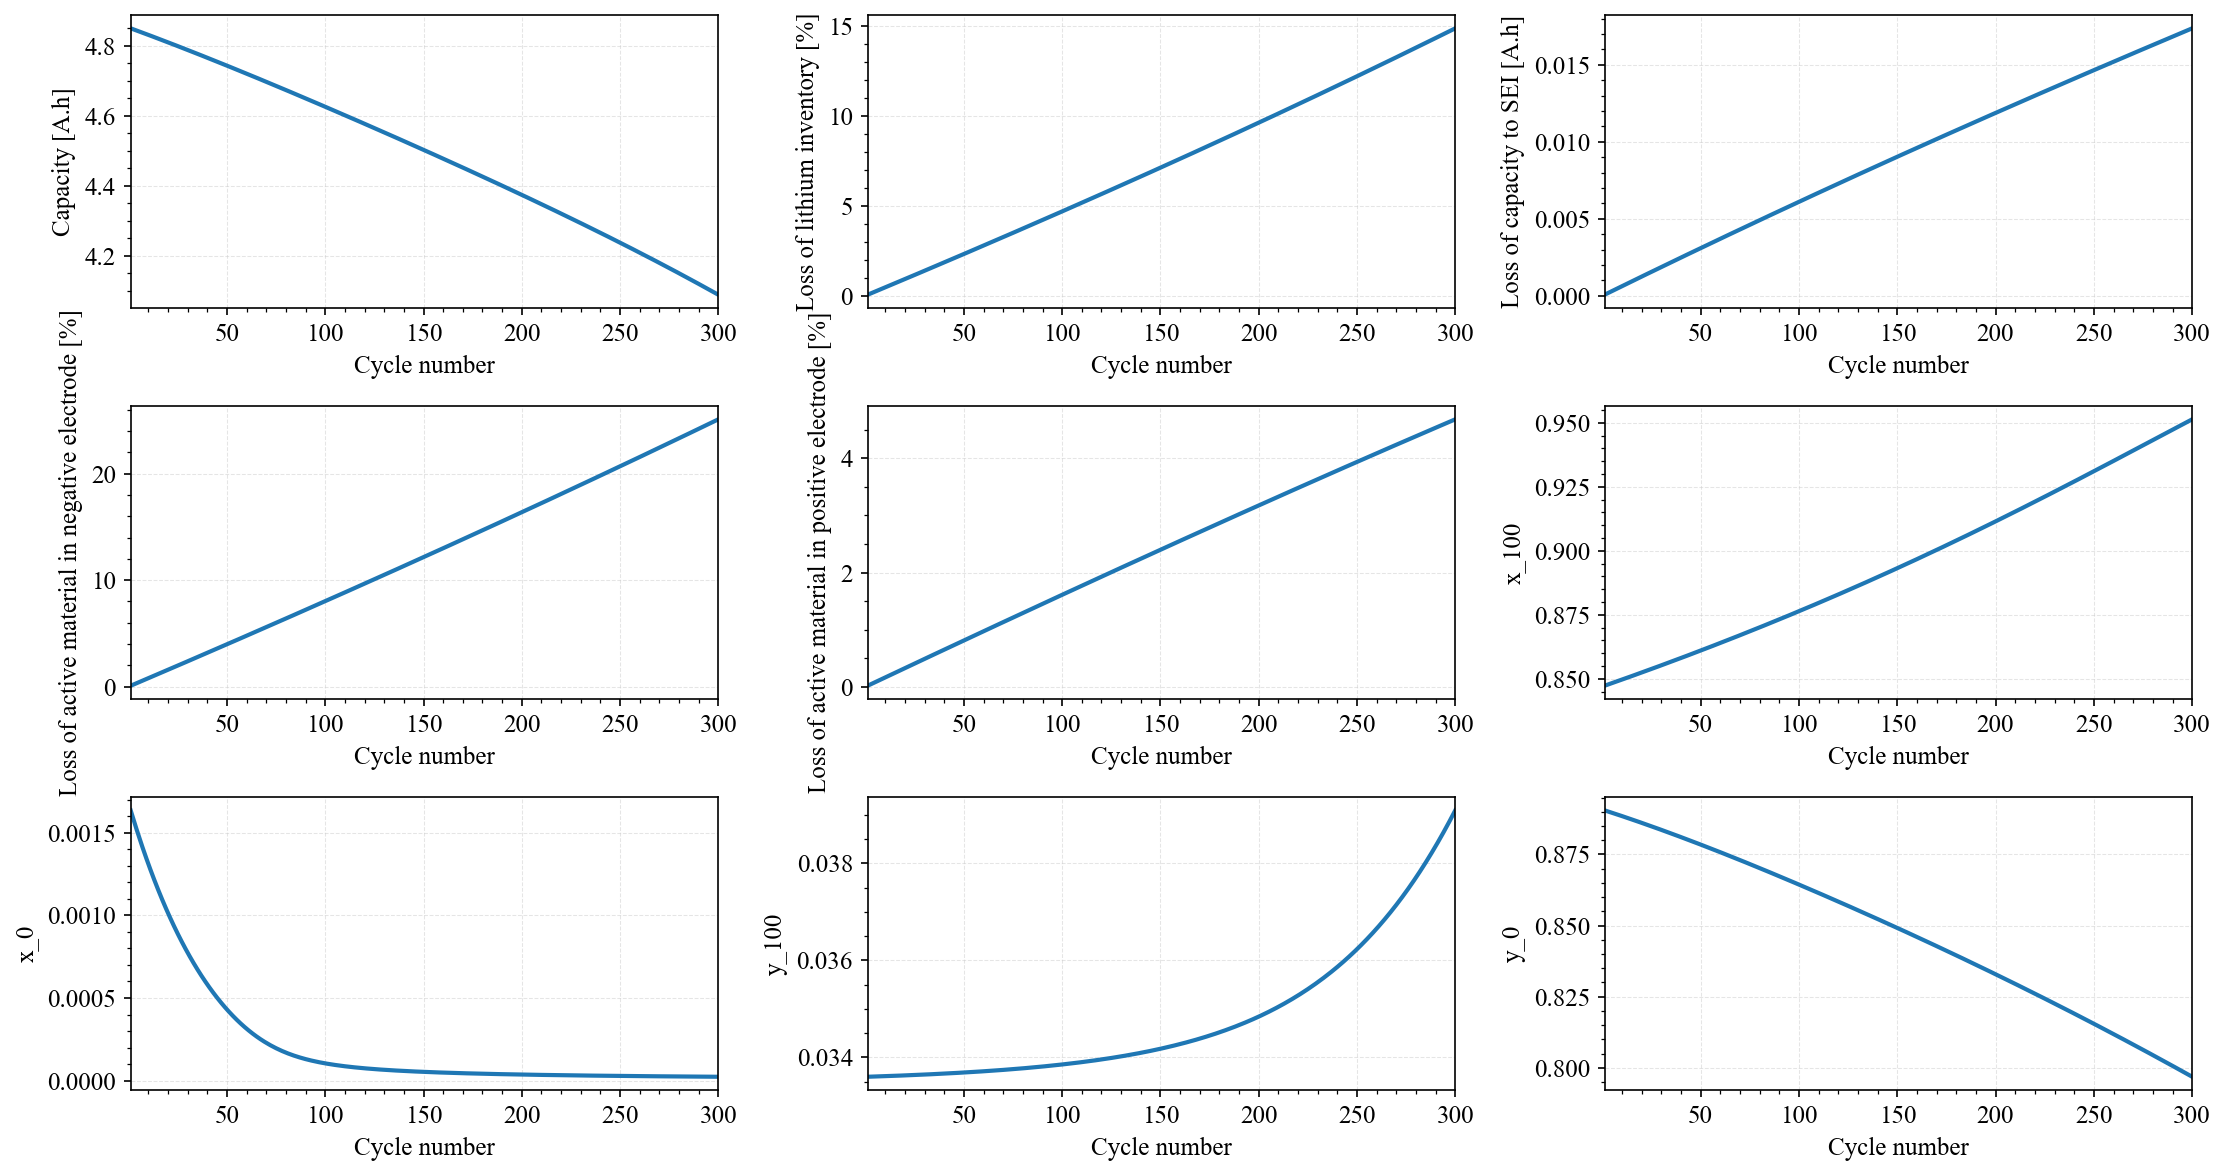

array([[<AxesSubplot: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [13]:
pybamm.plot_summary_variables(sol_long)

In [14]:
spm.variables.search("active material")

Loss of active material in negative electrode [%]
Loss of active material in positive electrode [%]
Negative electrode active material volume fraction
Negative electrode active material volume fraction change
Positive electrode active material volume fraction
Positive electrode active material volume fraction change
X-averaged negative electrode active material volume fraction
X-averaged negative electrode active material volume fraction change
X-averaged positive electrode active material volume fraction
X-averaged positive electrode active material volume fraction change


In [15]:
sim_long.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#         "Electrolyte concentration [mol.m-3]",
#         "Positive particle surface concentration [mol.m-3]",
        "Current [A]",
#         "Negative electrode potential [V]",
#         "Electrolyte potential [V]",
#         "Positive electrode potential [V]",
        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
#         "SEI thickness [m]",
        "Loss of capacity to SEI [A.h]",
        "Negative electrode capacity [A.h]",
        "Positive electrode capacity [A.h]",
        "Discharge capacity [A.h]",
        "X-averaged negative electrode active material volume fraction"

        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=453.6443205329312, step=4.536443205329312), …

In [16]:
#print(list(sol_long.summary_variables.keys()))

In [17]:
type(sol_long.summary_variables[list(sol_long.summary_variables.keys())[1]])

numpy.ndarray

In [18]:
# mdic={}
# for i in range (1):
# # range(len(sol_long.summary_variables)):
# #     stringing=''.join([list(sol_long.summary_variables.keys())[i]])
#     mdic={f"{i}": sol_long.summary_variables[list(sol_long.summary_variables.keys())[i]]}
# savemat("summary",mdic)


In [19]:
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries

ECM_res=sol_long.summary_variables["Local ECM resistance [Ohm]"]

ECM_whole_res=sol_long["Local ECM resistance [Ohm]"].entries
ECM_sum_res=sol_long.summary_variables["Local ECM resistance [Ohm]"]
ECM_sum_res_change=sol_long.summary_variables['Change in local ECM resistance [Ohm]']
cycle_time=sol_long.summary_variables['Time [s]']
# exp = 30e6*sol_0["Cell thickness change [m]"].entries
# exp_n = 30e6*sol_0["Negative Electrode thickness change [m]"].entries
# exp_p = 30e6*sol_0["Positive Electrode thickness change [m]"].entries
# ee_p = sol_0["X-averaged positive electrode porosity"].entries
# ee_n = sol_0["X-averaged negative electrode porosity"].entries
# ee_s = sol_0["X-averaged separator porosity"].entries
# j_n = sol_0["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
# j_p = sol_0["X-averaged positive electrode total interfacial current density [A.m-2]"].entries

# x = sol_0["x [m]"].entries
# c_e_0 = sol_0["Electrolyte concentration [mol.m-3]"].entries

In [20]:
ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
      "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled
       }
savemat("cell04_activeratio.mat",mdic)

In [ ]:
# savemat("x100_test", mdic)


In [ ]:
# print(x100)

In [ ]:
# import csv
# with open(r"F:\Git Hub rep\CRC\neew\PyBaMM\Untitled Folder\whatever.csv", 'w') as f:
#     # create the csv writer
#     writer = csv.writer(f)

# write a row to the csv file
# i=1
# for lines in sol_long.all_summary_variables:
# #     writer.writerow(words)
#     i=i+1
#     savemat(f'{i:02d}', lines)


In [ ]:
type(x100)

In [ ]:
sol_long.variables.search("charge")

In [ ]:
# plt.plot(sol_long["Time [s]"].entries[1:15133], sol_long["Current [A]"].entries[1:15133])

In [ ]:
# plt.plot(sol_long["Time [s]"].entries[1:15133], sol_long["Terminal voltage [V]"].entries[1:15133])

In [ ]:
 plt.plot(sol_long["Time [s]"].entries, 1-sol_long["Discharge capacity [A.h]"].entries/5)

In [ ]:
sol_long["Time [s]"].entries

In [ ]:
sim_long.plot(["Local ECM resistance",
"Local ECM resistance [Ohm]",
               "Resistance [Ohm]"])


In [ ]:
 plt.plot(cycle_num,ECM_res)

In [ ]:
sol_long.summary_variables 

In [ ]:
spm.variables.search("resistance")

In [ ]:
spm.param.n.prim